In [ ]:
########################
### K-means Notebook ###
########################

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# import data
data = pd.read_csv('data_20181101_d1_0800_0830.csv')
dataLarge = pd.read_csv('LargeFiles/speeds_per_grid_20181029_dX_0800_0830.csv')
# print(data.head().round(3))

# import data of the features
density = pd.read_csv('new_density_per_grid_20181101_d1_0800_0830.csv')  # big dataset: density = pd.read_csv('flows_per_grid_20181029_dX_0800_0830.csv')
speed = pd.read_csv('new_speeds_per_grid_20181101_d1_0800_0830.csv')   # big dataset: speed = pd.read_csv('speeds_per_grid_20181029_dX_0800_0830.csv')
acceleration = pd.read_csv('new_acceleration_per_grid_20181101_d1_0800_0830.csv')
direction = pd.read_csv('new_direction_per_grid_20181101_d1_0800_0830.csv')

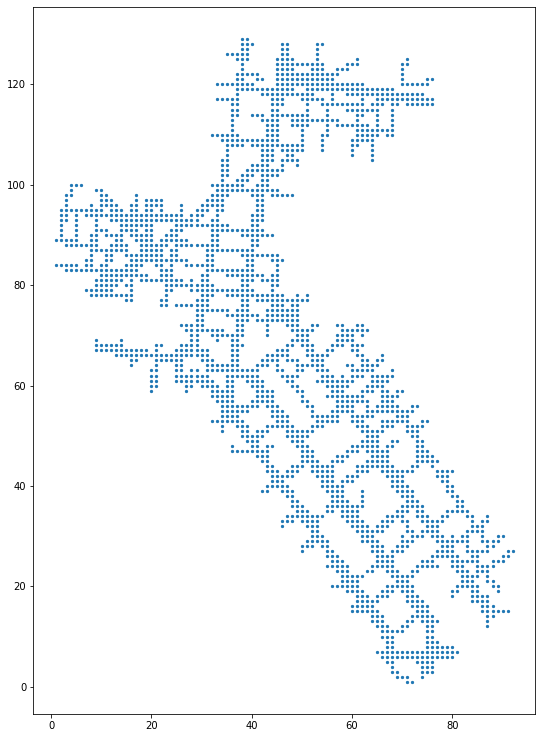

In [ ]:
plt.figure(figsize=(9,13))
plt.scatter(dataLarge['E_id'], dataLarge['N_id'], s=5)

# mean value of 4 attributes in 9 intervals, determine the maximum

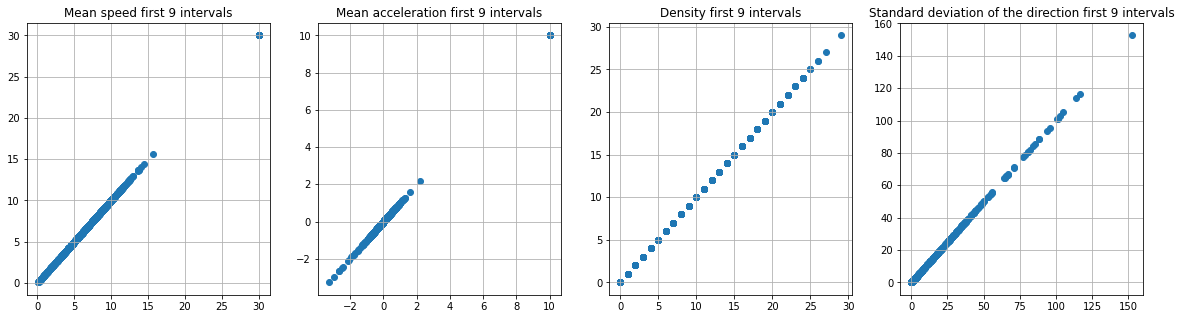

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.scatter(speed.iloc[:,2:11], speed.iloc[:,2:11])
plt.title('Mean speed first 9 intervals')
plt.grid()

plt.subplot(1,4,2)
plt.scatter(acceleration.iloc[:,2:11], acceleration.iloc[:,2:11])
plt.title('Mean acceleration first 9 intervals')
plt.grid()

plt.subplot(1,4,3)
plt.scatter(density.iloc[:,2:11], density.iloc[:,2:11])
plt.title('Density first 9 intervals')
plt.grid()

plt.subplot(1,4,4)
plt.scatter(direction.iloc[:,2:11], direction.iloc[:,2:11])
plt.title('Standard deviation of the direction first 9 intervals')
plt.grid()

In [ ]:
# Create an custom colormap for the different features source: https://jdherman.github.io/colormap/

# speed
C1 = ["#8B0000", "#ff0000", "#ffa700", "#fbff09", "#6bff00", "#31af2b", # Red to green
      "#e6e6e6"] # NaN

# acceleration
C2 = ["#8B0000", "#f10000", '#FF4A15', "#ffa700", '#FFCC6C', "#fbff09", 
       "#6bff00", '#278822', '#164F13', # Red to green
      "#e6e6e6"] # NaN

# density
C3 = ["#31af2b", "#6bff00", "#fbff09", "#ffa700", "#ff0000", "#8B0000"] # Green to red

# direction
C4 = ["#31af2b", "#6bff00", "#fbff09", "#ffa700", "#ff0000", "#8B0000"] # Green to red

# PCA
C5 = ["#31af2b", "#6bff00", "#fbff09", "#ffa700", "#ff0000"] # Green to red

# create the colormaps
cmSpeed = mpl.colors.ListedColormap(C1)
cmAcceleration = mpl.colors.ListedColormap(C2)
cmDensity = mpl.colors.ListedColormap(C3)
cmDirection = mpl.colors.ListedColormap(C4)
cmPCA = mpl.colors.ListedColormap(C5)

Text(0, 0.5, 'North')

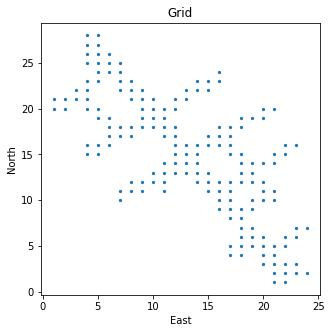

In [ ]:
# display the grid
plt.figure(figsize=(5,5))
plt.scatter(speed['E_id'], speed['N_id'],s=5)
plt.title('Grid')
plt.xlabel('East')
plt.ylabel('North')

### Function to create dataset for each time interval containing all 4 features

In [ ]:
def time(t):
    # create lists
    Eloc = []
    Nloc = []
    feature1 = []    # Speed
    feature2 = []    # Density
    feature3 = []    # Acceleration
    feature4 = []    # Direction

    for i in range(len(speed)):
        # select values which are not nan
        if speed.iloc[:,t+2].isnull().iloc[i] == False & density.iloc[:,t+2].isnull().iloc[i] == False:
                Eloc.append(speed.iloc[i,0])
                Nloc.append(speed.iloc[i,1])
                feature1.append(speed.iloc[i,t+2])
                feature2.append(density.iloc[i,t+2])
                feature3.append(acceleration.iloc[i, t+2])
                feature4.append(direction.iloc[i, t+2])

    # New dataset containing location and features
    data = {'Eloc': Eloc,
            'Nloc': Nloc,
            'Feature1_speed': feature1,
            'Feature2_density': feature2,
            'Feature3_acceleration': feature3,
            'Feature4_direction': feature4}

    return pd.DataFrame(data)

## Clustering functions (hierarchical and k-means)

In [ ]:
# function for hierachical clustering
def clustering_hierachical(df, n_features, n_clusters = 8):
    # use k-means to determine optimal amount of clusters
    x = []
    y = []
    for i in range(1, 60):
            # Perform K-means clustering
            kmeans = KMeans(n_clusters=i).fit(df.iloc[:,n_features:])
            x.append(i)
            y.append(kmeans.inertia_) 

    # find sudden stop location
    X = np.array(x)
    Y = np.array(y)
    der = []
    for i in range(0, len(X)-1):
        der.append(abs((Y[i+1]-Y[i])/(X[i+1]-X[i])))

    # find the 'sudden stop'
    for i in range(0, len(der)-1):
        if der[i] - der[i+1] < 0.2:
            optimal = X[i]+1
            #print('Optimal amount of hierarchical clusters is ', X[i]+1)
            break

    # Perform hierarchical clustering
    Z = hierarchy.linkage(df, 'single')
    return fcluster(Z, n_clusters, criterion='maxclust'), optimal

In [ ]:
# function for k-means clustering
def clustering_kmeans(df, n_features, n_clusters = 8):
    # use k-means to determine optimal amount of clusters
    x = []
    y = []
    for i in range(1, 60):
            # Perform K-means clustering
            kmeans = KMeans(n_clusters=i).fit(df.iloc[:,n_features:])
            x.append(i)
            y.append(kmeans.inertia_) 

    # find sudden stop location
    X = np.array(x)
    Y = np.array(y)
    der = []
    for i in range(0, len(X)-1):
        der.append(abs((Y[i+1]-Y[i])/(X[i+1]-X[i])))

    # find the 'sudden stop'
    for i in range(0, len(der)-1):
        if der[i] - der[i+1] < 0.2:
            optimal = X[i]+1
            #print('Optimal amount of k-means clusters is ', X[i]+1)
            break


    # perform k-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(df.iloc[:,n_features:])

    return kmeans.labels_, kmeans.cluster_centers_, optimal

## Determine the mean value of each cluster and add this value to the dataframe

In [ ]:
from tabulate import tabulate

# Function to determine the minimum, maximum and mean value of each cluster
def minmax(df, feature='Feature1_speed', n_clusters=8, method='K-means'):
    clasmin  = np.zeros(n_clusters+1)
    clasmax  = np.zeros(n_clusters+1)
    clasmean = np.zeros(n_clusters+1) 
    for i in range(0, n_clusters+1):
        clas = df[df["Cluster"]== i]
        clasmin[i] = round(np.min(clas[feature]), 3)  # minimum
        clasmax[i] = round(np.max(clas[feature]), 3)  # maximum
        clasmean[i] = round(np.mean(clas[feature]), 3) # mean

    if method == 'K-means': 
        head = ["Cluster number", "Min value", "Max value", "Mean value", "Range"]
        table = []
        for i in range(0, n_clusters):
            table.append(['Cluster '+str(i), clasmin[i], clasmax[i], clasmean[i], clasmax[i]-clasmin[i]])
        arr = tabulate(table, headers=head) 
    
    if method == 'Hierarchical':
        head = ["Cluster number", "Min value", "Max value", "Mean value", "Range"]
        table = []
        for i in range(1, n_clusters+1):
            table.append(['Cluster '+str(i), clasmin[i], clasmax[i], clasmean[i], clasmax[i]-clasmin[i]])
        arr = tabulate(table, headers=head)    

    return arr, clasmean

In [ ]:
# Function to add the mean value to the dataframe
def add_value_kmeans(df, n_features=1, feature='Feature1_speed', n_clusters=8, table=False):
  f1 = clustering_kmeans(df, n_features)[0]
  opt = clustering_kmeans(df, n_features)[2]
  df['Cluster'] = f1
  meanF1 = (minmax(df, feature, n_clusters)[1])[:n_clusters]
  mean = f1

  if table == True:

    print((minmax(df, feature, n_clusters, method='K-means')[0]))

  for i in range(len(meanF1)):
    mean = np.where(mean == i, meanF1[i], mean)

  df['Cluster_value'] = mean
  return df


def add_value_hierarch(df, n_features=1, feature='Feature1_speed', n_clusters=8, table=False):
  f1 = clustering_hierachical(df, n_features)[0]
  opt = clustering_hierachical(df, n_features)[1]
  df['Cluster'] = f1
  meanF1 = (minmax(df, feature, n_clusters, method='Hierarchical')[1])[1:]
  mean = f1

  if table == True:
    print('')
    print(str(feature) + ' with number of clusters is ' + str(n_clusters) + ' and optimal number of clusters is '+ str(opt))
    print((minmax(df, feature, n_clusters, method='Hierarchical')[0]))

  for i in range(len(meanF1)):
    mean = np.where(mean == i+1, meanF1[i], mean)

  df['Cluster_value'] = mean
  return df

## Determine the correlation between the different features

In [ ]:
# Create the dataset including all features
dfF1234 = time(0)     # All features

# Select the features
f = dfF1234.drop(columns=['Eloc', 'Nloc'])

display(f.corr(method='pearson').style.background_gradient(cmap='coolwarm'))

# Normalize the data
[f[col].update((f[col] - f[col].min()) / (f[col].max() - f[col].min())) for col in f.columns]

# Calculate the correlation
display(f.corr(method='pearson').style.background_gradient(cmap='coolwarm'))

,Feature1_speed,Feature2_density,Feature3_acceleration,Feature4_direction
Feature1_speed,1.000000,-0.568711,0.981633,-0.444584
Feature2_density,-0.568711,1.000000,-0.604375,0.312769
Feature3_acceleration,0.981633,-0.604375,1.000000,-0.375502
Feature4_direction,-0.444584,0.312769,-0.375502,1.000000


,Feature1_speed,Feature2_density,Feature3_acceleration,Feature4_direction
Feature1_speed,1.000000,-0.568711,0.981633,-0.444584
Feature2_density,-0.568711,1.000000,-0.604375,0.312769
Feature3_acceleration,0.981633,-0.604375,1.000000,-0.375502
Feature4_direction,-0.444584,0.312769,-0.375502,1.000000


In [ ]:
# Correlation without normalizing
for i in range(0, 13):
    dfF1234 = time(i)
    features = dfF1234.iloc[:,2:]
    print('Correlation of timeinterval ' + str(i))
    display((features.corr()).style.background_gradient(cmap='coolwarm'))

Correlation of timeinterval 0


,Feature1_speed,Feature2_density,Feature3_acceleration,Feature4_direction
Feature1_speed,1.000000,-0.568711,0.981633,-0.444584
Feature2_density,-0.568711,1.000000,-0.604375,0.312769
Feature3_acceleration,0.981633,-0.604375,1.000000,-0.375502
Feature4_direction,-0.444584,0.312769,-0.375502,1.000000


Correlation of timeinterval 1


,Feature1_speed,Feature2_density,Feature3_acceleration,Feature4_direction
Feature1_speed,1.000000,-0.634809,0.972920,-0.487362
Feature2_density,-0.634809,1.000000,-0.671025,0.375966
Feature3_acceleration,0.972920,-0.671025,1.000000,-0.370557
Feature4_direction,-0.487362,0.375966,-0.370557,1.000000


Correlation of timeinterval 2


,Feature1_speed,Feature2_density,Feature3_acceleration,Feature4_direction
Feature1_speed,1.000000,-0.454084,0.970691,-0.445156
Feature2_density,-0.454084,1.000000,-0.499410,0.297117
Feature3_acceleration,0.970691,-0.499410,1.000000,-0.338102
Feature4_direction,-0.445156,0.297117,-0.338102,1.000000


Correlation of timeinterval 3


,Feature1_speed,Feature2_density,Feature3_acceleration,Feature4_direction
Feature1_speed,1.000000,-0.560777,0.975063,-0.391157
Feature2_density,-0.560777,1.000000,-0.573517,0.257144
Feature3_acceleration,0.975063,-0.573517,1.000000,-0.303963
Feature4_direction,-0.391157,0.257144,-0.303963,1.000000


Correlation of timeinterval 4


,Feature1_speed,Feature2_density,Feature3_acceleration,Feature4_direction
Feature1_speed,1.000000,-0.617331,0.977959,-0.459403
Feature2_density,-0.617331,1.000000,-0.647880,0.279195
Feature3_acceleration,0.977959,-0.647880,1.000000,-0.344201
Feature4_direction,-0.459403,0.279195,-0.344201,1.000000


Correlation of timeinterval 5


,Feature1_speed,Feature2_density,Feature3_acceleration,Feature4_direction
Feature1_speed,1.000000,-0.486828,0.968232,-0.466857
Feature2_density,-0.486828,1.000000,-0.583396,0.202549
Feature3_acceleration,0.968232,-0.583396,1.000000,-0.346285
Feature4_direction,-0.466857,0.202549,-0.346285,1.000000


Correlation of timeinterval 6


,Feature1_speed,Feature2_density,Feature3_acceleration,Feature4_direction
Feature1_speed,1.000000,-0.457898,0.967587,-0.394990
Feature2_density,-0.457898,1.000000,-0.539061,0.175284
Feature3_acceleration,0.967587,-0.539061,1.000000,-0.269461
Feature4_direction,-0.394990,0.175284,-0.269461,1.000000


Correlation of timeinterval 7


,Feature1_speed,Feature2_density,Feature3_acceleration,Feature4_direction
Feature1_speed,1.000000,-0.535145,0.978169,-0.445515
Feature2_density,-0.535145,1.000000,-0.603862,0.378732
Feature3_acceleration,0.978169,-0.603862,1.000000,-0.363985
Feature4_direction,-0.445515,0.378732,-0.363985,1.000000


Correlation of timeinterval 8


,Feature1_speed,Feature2_density,Feature3_acceleration,Feature4_direction
Feature1_speed,1.000000,-0.455493,0.979002,-0.393442
Feature2_density,-0.455493,1.000000,-0.526094,0.114862
Feature3_acceleration,0.979002,-0.526094,1.000000,-0.303108
Feature4_direction,-0.393442,0.114862,-0.303108,1.000000


Correlation of timeinterval 9


,Feature1_speed,Feature2_density,Feature3_acceleration,Feature4_direction
Feature1_speed,1.000000,-0.383352,0.967926,-0.405566
Feature2_density,-0.383352,1.000000,-0.437960,0.142516
Feature3_acceleration,0.967926,-0.437960,1.000000,-0.292220
Feature4_direction,-0.405566,0.142516,-0.292220,1.000000


Correlation of timeinterval 10


,Feature1_speed,Feature2_density,Feature3_acceleration,Feature4_direction
Feature1_speed,1.000000,-0.502942,0.969296,-0.441800
Feature2_density,-0.502942,1.000000,-0.595316,0.129568
Feature3_acceleration,0.969296,-0.595316,1.000000,-0.319744
Feature4_direction,-0.441800,0.129568,-0.319744,1.000000


Correlation of timeinterval 11


,Feature1_speed,Feature2_density,Feature3_acceleration,Feature4_direction
Feature1_speed,1.000000,-0.491397,0.964979,-0.463144
Feature2_density,-0.491397,1.000000,-0.548293,0.147385
Feature3_acceleration,0.964979,-0.548293,1.000000,-0.331568
Feature4_direction,-0.463144,0.147385,-0.331568,1.000000


Correlation of timeinterval 12


,Feature1_speed,Feature2_density,Feature3_acceleration,Feature4_direction
Feature1_speed,1.000000,-0.475792,0.976670,-0.408374
Feature2_density,-0.475792,1.000000,-0.518505,0.243909
Feature3_acceleration,0.976670,-0.518505,1.000000,-0.319810
Feature4_direction,-0.408374,0.243909,-0.319810,1.000000


**Meaning of different correlation values**

• Exactly –1. A perfect downhill (negative) linear relationship

• –0.70. A strong downhill (negative) linear relationship

• –0.50. A moderate downhill (negative) relationship

• –0.30. A weak downhill (negative) linear relationship

• 0. 0. No linear relationship

• +0.30. A weak uphill (positive) linear relationship +0.30.

• +0.50. A moderate uphill (positive) relationship +0.50.

• +0.70. A strong uphill (positive) linear relationsh +0.70. ip

• Exactly +1. A perfect uphill (positive) linear relationship

Source: http://mathaction.pbworks.com/w/file/fetch/133081815/3.CorrelationCoefficient.pdf



**Correlation interpertation**

- Speed and density: -0.57 moderate negative relationship
- Speed and acceleration: 0.98 positive linear relationship
- Speed and direction: -0.44 moderate negative relationship
- Density and acceleration: -0.60 moderate negative relationship
- Density and direction: 0.31 weak positive linear relationship
- Acceleration and direction: -0.38 weak negative linear relationship

Conclusion: skip combination with speed and acceleration

## Determine which clustering method we should use: k-means or hierarchical

Cluster number      Min value    Max value    Mean value    Range
----------------  -----------  -----------  ------------  -------
Cluster 0               6.221       12.145         9.397    5.924
Cluster 1              30           30            30        0
Cluster 2               7.668       13.01         10.689    5.342
Cluster 3               0.269        6.36          3.901    6.091
Cluster 4              30           30            30        0
Cluster 5              30           30            30        0
Cluster 6               5.798       11.789         9.531    5.991
Cluster 7               0.327        6.302         3.206    5.975


KeyboardInterrupt: 

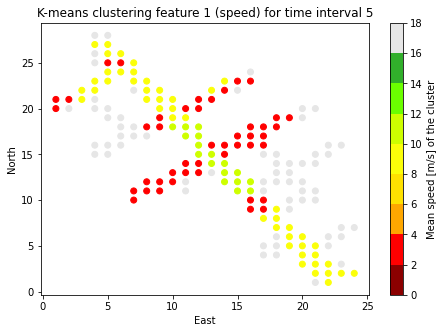

In [ ]:
# Compare hierarchical with k-means
for i in range(5, 6):
  dfF1 = time(i).drop(columns=['Feature2_density', 'Feature3_acceleration', 'Feature4_direction'])
  dfF1 = add_value_kmeans(dfF1, table=True)
  plt.figure(figsize=(25, 5))
  plt.subplot(1,3,1) 
  plt.scatter(dfF1['Eloc'], dfF1['Nloc'], c=dfF1['Cluster_value'], cmap=cmSpeed, vmin=0, vmax=18)
  plt.title('K-means clustering feature 1 (speed) for time interval ' + str(i))
  plt.ylabel('North')
  plt.xlabel('East')
  cbar = plt.colorbar();
  cbar.set_label('Mean speed [m/s] of the cluster');

  dfF1 = time(i).drop(columns=['Feature2_density', 'Feature3_acceleration', 'Feature4_direction'])
  dfF1 = add_value_hierarch(dfF1, table=True)
  plt.subplot(1,3,2)
  plt.scatter(dfF1['Eloc'], dfF1['Nloc'], c=dfF1['Cluster_value'], cmap=cmSpeed, vmin=0, vmax=18)
  plt.title('Hierarchical clustering feature 1 (speed) for time interval ' + str(i))
  plt.ylabel('North')
  plt.xlabel('East')
  cbar = plt.colorbar()
  cbar.set_label('Mean speed [m/s] of the cluster'); 

  plt.subplot(1,3,3)
  plt.scatter(dfF1['Eloc'], dfF1['Nloc'], c=dfF1['Feature1_speed'], cmap=cmSpeed, vmin=0, vmax=18)
  plt.title('Mean speed of grid point for time interval ' + str(i))
  plt.ylabel('North')
  plt.xlabel('East')
  cbar = plt.colorbar()
  cbar.set_label('Mean speed [m/s]'); 

## Determining the vmin and vmax value for the different features (colorscale) 


Feature1_speed with number of clusters is 8 and optimal number of clusters is 9
Cluster number      Min value    Max value    Mean value    Range
----------------  -----------  -----------  ------------  -------
Cluster 0              30           30            30        0
Cluster 1               2.693        9.632         6.828    6.939
Cluster 2               0.827        9.983         5.456    9.156
Cluster 3               0.437       11.203         8.274   10.766
Cluster 4              30           30            30        0
Cluster 5              30           30            30        0
Cluster 6               8.976       13.741        11.521    4.765
Cluster 7               0.948        8.801         6.289    7.853

Feature2_density with number of clusters is 8 and optimal number of clusters is 10
Cluster number      Min value    Max value    Mean value    Range
----------------  -----------  -----------  ------------  -------
Cluster 0                   5           12         9   

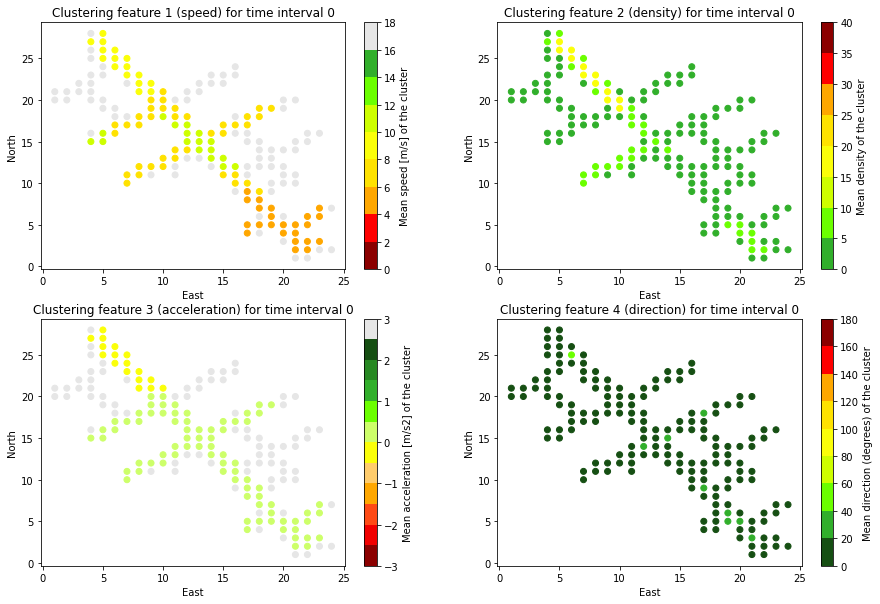

In [ ]:
dfF1 = time(0).drop(columns=['Feature2_density', 'Feature3_acceleration', 'Feature4_direction'])
dfF1 = add_value_kmeans(dfF1, feature='Feature1_speed', table=True)
dfF2 = time(0).drop(columns=['Feature1_speed', 'Feature3_acceleration', 'Feature4_direction'])
dfF2 = add_value_kmeans(dfF2, feature='Feature2_density', table=True)
dfF3 = time(0).drop(columns=['Feature1_speed', 'Feature2_density', 'Feature4_direction'])
dfF3 = add_value_kmeans(dfF3, feature='Feature3_acceleration', table=True)
dfF4 = time(0).drop(columns=['Feature1_speed', 'Feature2_density', 'Feature3_acceleration'])
dfF4 = add_value_kmeans(dfF4, feature='Feature4_direction', table=True)

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.scatter(dfF1['Eloc'], dfF1['Nloc'], c=dfF1['Cluster_value'], cmap=cmSpeed, vmin=0, vmax=18)
plt.title('Clustering feature 1 (speed) for time interval 0')
plt.ylabel('North')
plt.xlabel('East')
cbar = plt.colorbar()#ticks=np.linspace(0,32,9));
#plt.clim(0, 32)
cbar.set_label('Mean speed [m/s] of the cluster');

plt.subplot(2,2,2)
plt.scatter(dfF2['Eloc'], dfF2['Nloc'], c=dfF2['Cluster_value'], cmap=cmDensity, vmin=0, vmax=40)
plt.title('Clustering feature 2 (density) for time interval 0')
plt.ylabel('North')
plt.xlabel('East')
cbar = plt.colorbar()#ticks=np.linspace(0,32,9));
#plt.clim(0, 32)
cbar.set_label('Mean density of the cluster');

plt.subplot(2,2,3)
plt.scatter(dfF3['Eloc'], dfF3['Nloc'], c=dfF3['Cluster_value'], cmap=cmAcceleration, vmin=-3, vmax=3)
plt.title('Clustering feature 3 (acceleration) for time interval 0')
plt.ylabel('North')
plt.xlabel('East')
cbar = plt.colorbar()#ticks=np.linspace(0,32,9));
#plt.clim(0, 32)
cbar.set_label('Mean acceleration [m/s2] of the cluster');

plt.subplot(2,2,4)
plt.scatter(dfF4['Eloc'], dfF4['Nloc'], c=dfF4['Cluster_value'], cmap=cmDirection, vmin=0, vmax=180)
plt.title('Clustering feature 4 (direction) for time interval 0')
plt.ylabel('North')
plt.xlabel('East')
cbar = plt.colorbar()#ticks=np.linspace(0,32,9));
#plt.clim(0, 360)
cbar.set_label('Mean direction (degrees) of the cluster');

## Compute k-means using different features for the first 9 time intervals

Min and max values time interval 0
min 5.456 max 11.521
Min and max values time interval 1
min 3.227 max 11.423
Min and max values time interval 2
min 2.963 max 8.68
Min and max values time interval 3
min 4.028 max 9.269
Min and max values time interval 4
min 2.261 max 8.926
Min and max values time interval 5
min 3.206 max 10.689
Min and max values time interval 6
min 2.073 max 9.308
Min and max values time interval 7
min 2.231 max 8.107
Min and max values time interval 8
min 2.841 max 8.514


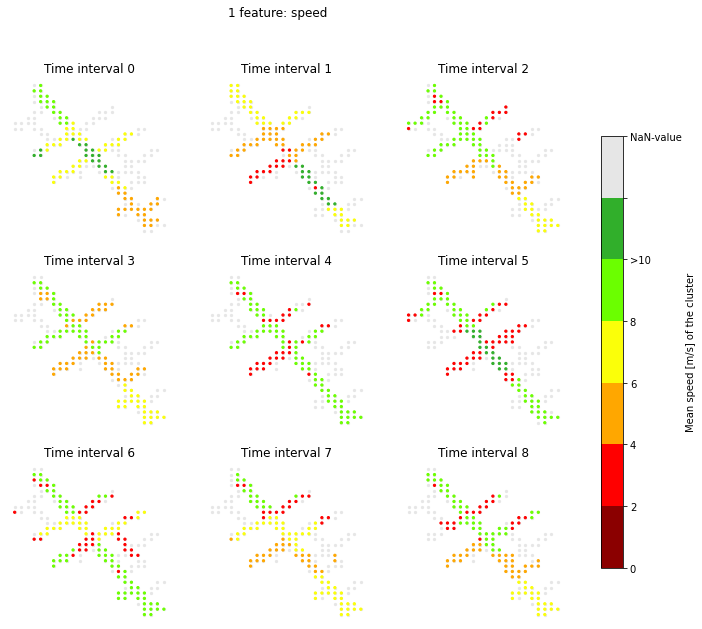

In [ ]:
# Feature 1: speed
N = 9
ncols = 3
nrows = int(np.ceil(N/ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(10,10))
axs = axs.flat

[axi.set_axis_off() for axi in axs]

for t in range(0, N):
  dfF1 = time(t).drop(columns=['Feature2_density', 'Feature3_acceleration', 'Feature4_direction'])
  dfF1 = add_value_kmeans(dfF1, table=False)
  dfF1['Cluster_value'] = dfF1['Cluster_value'].replace(30, np.nan)
  print('Min and max values time interval '+str(t))
  print('min', dfF1['Cluster_value'].min(), 'max', dfF1['Cluster_value'].max())

  # display the clusters on a map
  figs = axs[t].scatter(dfF1['Eloc'], dfF1['Nloc'], s = 5, c="#e6e6e6")    
  figs = axs[t].scatter(dfF1['Eloc'], dfF1['Nloc'], c=dfF1['Cluster_value'], s = 5, cmap=cmSpeed, vmin=0, vmax=14)  
  titlestr = 'Time interval '+str(t)
  axs[t].set_title(titlestr)

plt.suptitle('1 feature: speed')
cbar_ax = fig.add_axes([0.95, 0.20, 0.03, 0.6])
cbar = fig.colorbar(figs, cax=cbar_ax)
cbar.set_ticks(np.linspace(0, 14, 8))
cbar.set_ticklabels(['0','2','4','6','8','>10','','NaN-value'])
cbar.set_label('Mean speed [m/s] of the cluster');

Min and max values time interval 0
min 0.219 max 18.583
Min and max values time interval 1
min 0.042 max 13.6
Min and max values time interval 2
min 0.952 max 23.333
Min and max values time interval 3
min 0.462 max 19.5
Min and max values time interval 4
min 0.226 max 19.143
Min and max values time interval 5
min 0.333 max 16.688
Min and max values time interval 6
min 0.654 max 20.0
Min and max values time interval 7
min 0.484 max 17.545
Min and max values time interval 8
min 0.581 max 23.143


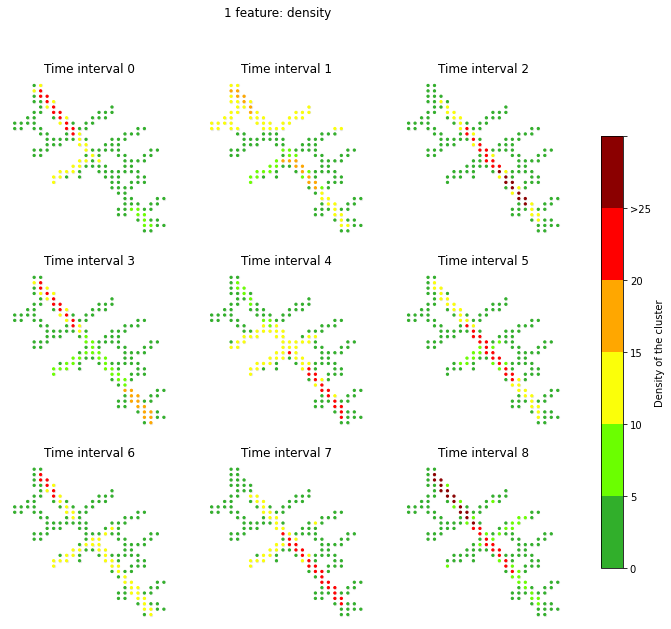

In [ ]:
# Feature 2: density
N = 9
ncols = 3
nrows = int(np.ceil(N/ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(10,10))
axs = axs.flat

[axi.set_axis_off() for axi in axs]

for t in range(0, N):
  figs = axs[t].scatter(dfF1['Eloc'], dfF1['Nloc'], s = 5, c="#e6e6e6")  

  dfF1 = time(t).drop(columns=['Feature1_speed', 'Feature3_acceleration', 'Feature4_direction'])
  dfF1 = add_value_kmeans(dfF1, feature='Feature2_density')
  print('Min and max values time interval '+str(t))
  print('min', dfF1['Cluster_value'].min(), 'max', dfF1['Cluster_value'].max())

  # display the clusters on a map
  figs = axs[t].scatter(dfF1['Eloc'], dfF1['Nloc'], c=dfF1['Cluster_value'], s=5, cmap=cmDensity, vmin=0, vmax=25)
  titlestr = 'Time interval '+str(t)
  axs[t].set_title(titlestr)

plt.suptitle('1 feature: density');
cbar_ax = fig.add_axes([0.95, 0.20, 0.03, 0.6])
cbar = fig.colorbar(figs, cax=cbar_ax)
cbar.set_ticks(np.linspace(0, 25, 7))
cbar.set_ticklabels(['0','5','10','15','20','>25',''])
cbar.set_label('Density of the cluster');

Min and max values time interval 0
min -0.127 max 0.199
Min and max values time interval 1
min -0.289 max 0.125
Min and max values time interval 2
min -0.183 max 0.088
Min and max values time interval 3
min -0.424 max 0.023
Min and max values time interval 4
min -0.143 max 0.125


KeyboardInterrupt: 

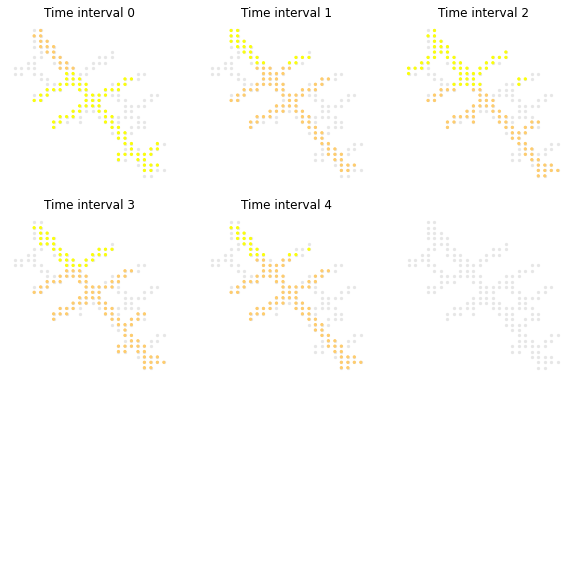

In [ ]:
# Feature 3: acceleration
N = 9
ncols = 3
nrows = int(np.ceil(N/ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(10,10))
axs = axs.flat

[axi.set_axis_off() for axi in axs]

for t in range(0, N):
  figs = axs[t].scatter(dfF1['Eloc'], dfF1['Nloc'], s = 5, c="#e6e6e6")  

  dfF1 = time(t).drop(columns=['Feature1_speed', 'Feature2_density', 'Feature4_direction'])
  dfF1 = add_value_kmeans(dfF1, feature='Feature3_acceleration')

  figs = axs[t].scatter(dfF1['Eloc'], dfF1['Nloc'], c=dfF1['Cluster_value'], s = 5, cmap=cmAcceleration, vmin=-3, vmax=3)

  # display the clusters on a map
  titlestr = 'Time interval '+str(t)
  axs[t].set_title(titlestr)

plt.suptitle('1 feature: acceleration');
cbar_ax = fig.add_axes([0.95, 0.20, 0.03, 0.6])
cbar = fig.colorbar(figs, cax=cbar_ax)
cbar.set_label('Mean acceleration [m/s^2] of the cluster');

Min and max values time interval 0
min 0.594 max 49.545
Min and max values time interval 1
min 0.962 max 100.949
Min and max values time interval 2
min 1.178 max 80.856
Min and max values time interval 3
min 1.286 max 97.411
Min and max values time interval 4
min 0.917 max 84.767
Min and max values time interval 5
min 0.873 max 105.036
Min and max values time interval 6
min 1.143 max 104.05
Min and max values time interval 7
min 1.101 max 77.011
Min and max values time interval 8
min 1.283 max 152.61


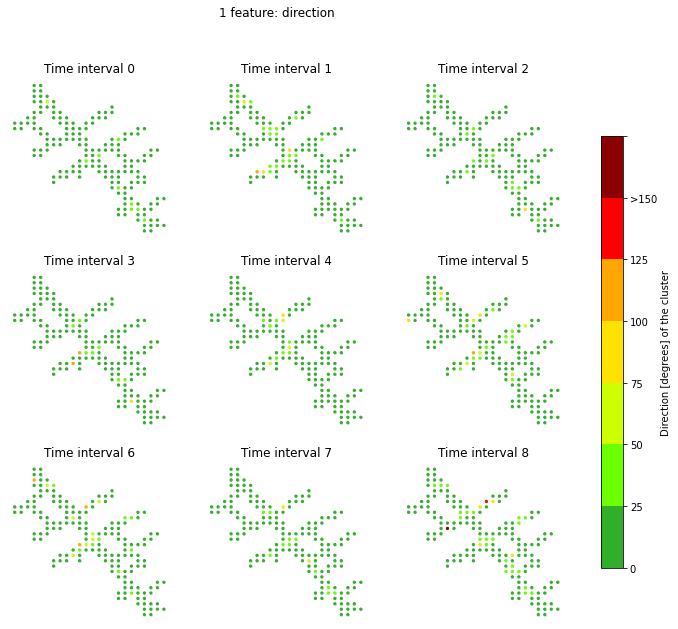

In [ ]:
# Feature 4: direction
N = 9
ncols = 3
nrows = int(np.ceil(N/ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(10,10))
axs = axs.flat

[axi.set_axis_off() for axi in axs]

for t in range(0, N):
  figs = axs[t].scatter(dfF1['Eloc'], dfF1['Nloc'], s = 5, c="#e6e6e6")  

  dfF1 = time(t).drop(columns=['Feature1_speed', 'Feature2_density', 'Feature3_acceleration'])
  dfF1 = add_value_kmeans(dfF1, feature='Feature4_direction')
  print('Min and max values time interval '+str(t))
  print('min', dfF1['Cluster_value'].min(), 'max', dfF1['Cluster_value'].max())
  

  # display the clusters on a map
  figs = axs[t].scatter(dfF1['Eloc'], dfF1['Nloc'], c=dfF1['Cluster_value'], s = 5, cmap=cmDirection, vmin=0 , vmax=125)
  titlestr = 'Time interval '+str(t)
  axs[t].set_title(titlestr)

plt.suptitle('1 feature: direction');
cbar_ax = fig.add_axes([0.95, 0.20, 0.03, 0.6])
cbar = fig.colorbar(figs, cax=cbar_ax)
cbar.set_ticks(np.linspace(0, 125, 7))
cbar.set_ticklabels(['0','25','50','75','100','>125',''])
cbar.set_label('Direction [degrees] of the cluster');

## PCA using 2 features

In [ ]:
def PCA_calculation(data, f1='Feature1_speed', f2='Feature2_density', n_clus=8):
# ''' data is the time function, which is a dataset which contains the location and the different features '''
    ###########
    ### PCA ###
    ###########
    # Create dataset with only the features
    f_n = data.drop(columns=['Eloc', 'Nloc'])
    
    # Normalization
    std_features = StandardScaler().fit_transform(f_n)

    # PCA 
    pca = PCA(n_components=2)

    # Calculate principal components (new information obtained from the 2 features)
    principalComponents = pca.fit_transform(std_features)
    PCA_components = pd.DataFrame(principalComponents)
    data['PCA0'] = PCA_components.iloc[:,0]
    data['PCA1'] = PCA_components.iloc[:,1]

    # Create model using PCA
    model = KMeans(n_clusters=n_clus)
    model.fit(PCA_components)
    label = model.predict(PCA_components)

    # Add label to table
    data['Cluster'] = label
    
    #############################################
    ### Add a meaningful value to the dataset ###
    #############################################
    # Replace the 'old' nan values with NaN
    f_n[f1] = f_n[f1].replace(f_n[f1].max(), np.nan)
    [f_n[col].update((f_n[col] - f_n[col].min()) / (f_n[col].max() - f_n[col].min())) for col in f_n.columns]
    f_n['Transform'] = 1 - f_n[f1] 
    f_n['Average_norm'] = (f_n['Transform'] + f_n[f2])/2
    f_n = f_n.fillna(4)

    # Add the average of the normalized features to the data
    data['Value'] = f_n['Average_norm']

    mean_clas = minmax(data, feature='Value', n_clusters=n_clus)[1]
    mean = label

    for i in range(len(mean_clas)):
        mean = np.where(mean == i, mean_clas[i], mean)

    data['Cluster_value'] = mean
    return data

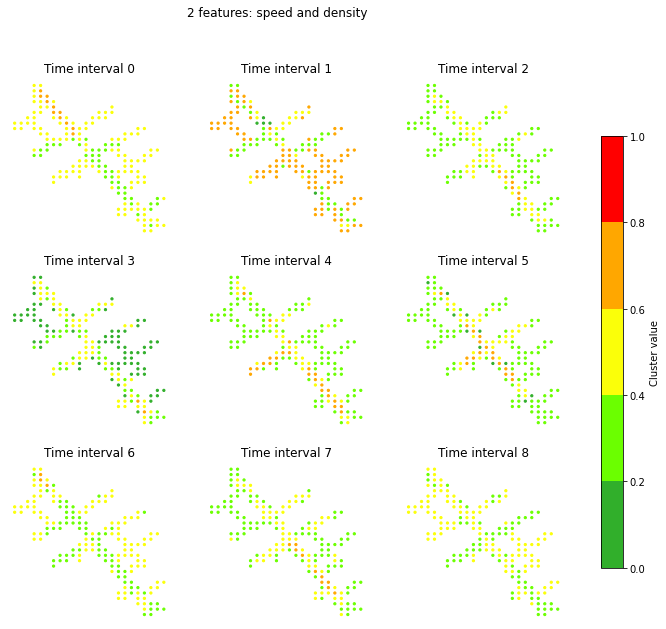

In [ ]:
# Features: speed and density
N = 9
ncols = 3
nrows = int(np.ceil(N/ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(10,10))
axs = axs.flat

[axi.set_axis_off() for axi in axs]

for t in range(0, N):
  data2 = PCA_calculation(time(t).drop(columns=['Feature3_acceleration', 'Feature4_direction']))
  figs = axs[t].scatter(data2['Eloc'], data2['Nloc'], c=data2['Cluster_value'], s = 5, cmap=cmPCA, vmin=0 , vmax=1)

  # display the clusters on a map
  titlestr = 'Time interval '+str(t)
  axs[t].set_title(titlestr)

plt.suptitle('2 features: speed and density');
cbar_ax = fig.add_axes([0.95, 0.20, 0.03, 0.6])
cbar = fig.colorbar(figs, cax=cbar_ax)
cbar.set_label('Cluster value');

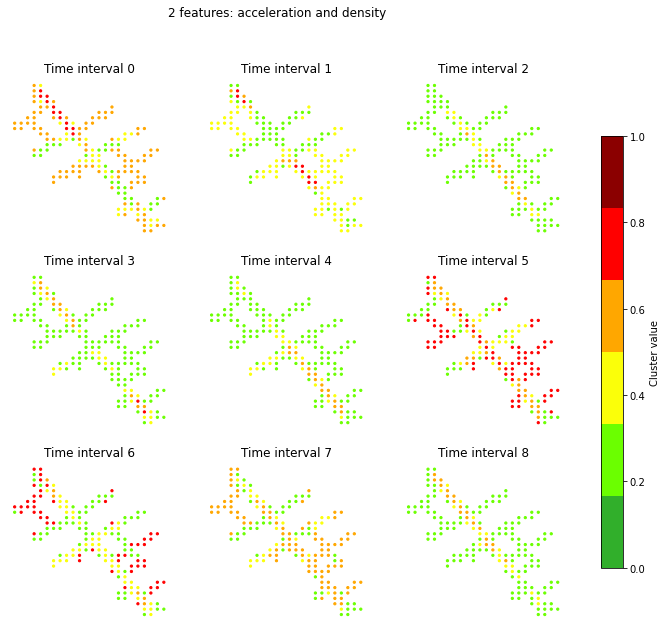

In [ ]:
# Features: acceleration and density
N = 9
ncols = 3
nrows = int(np.ceil(N/ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(10,10))
axs = axs.flat

[axi.set_axis_off() for axi in axs]

for t in range(0, N):
  data2 = PCA_calculation(time(t).drop(columns=['Feature1_speed', 'Feature4_direction']),f1='Feature3_acceleration')
  figs = axs[t].scatter(data2['Eloc'], data2['Nloc'], c=data2['Cluster_value'], s = 5, cmap=cmPCA, vmin=0 , vmax=1)

  # display the clusters on a map
  titlestr = 'Time interval '+str(t)
  axs[t].set_title(titlestr)

plt.suptitle('2 features: acceleration and density');
cbar_ax = fig.add_axes([0.95, 0.20, 0.03, 0.6])
cbar = fig.colorbar(figs, cax=cbar_ax)
cbar.set_label('Cluster value');

In [ ]:
#cbar.set_ticks(np.linspace(0, 1, 6))
#cbar.set_ticklabels(['0','5','10','15','20','>25',''])

print(np.linspace(0,1,6))

[0.  0.2 0.4 0.6 0.8 1. ]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=dc8bb720-d815-4ecd-8bea-56e83d6bf798' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>